<a href="https://colab.research.google.com/github/sabrinacorrea/S1S2randomforest/blob/master/SAR2_Semantic_Segmentation_Random_Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Semantic Segmentation Random Forest 

__Authors:__ Sabrina Corrêa and Vania Oliveira <br>
__Creation:__ 04/12/2019 <br>
__Lad Modified:__ 12/12/2019 <br>
__Description:__ This script performs a Pixel Based Classification using Random Forest (RF)

## References

https://spectraldifferences.wordpress.com/2014/09/07/object-based-classification-using-random-forests/
https://www.cse.huji.ac.il/~daphna/course/CoursePapers/bosch07a.pdf <br>
Package SAR: https://pypi.org/project/pyroSAR/ <br>

RF Decition Tree showing: https://jakevdp.github.io/PythonDataScienceHandbook/05.08-random-forests.html
<br><br>
### Getting Sentinel-1 and Sentinel-2 data
Please refer to the URLs below to download both data:


> Sentinel-1: https://code.earthengine.google.com/972384e7170175e17886ebe2705636e3


> Sentinel-2: https://code.earthengine.google.com/7141bbf09864f4271aff1c079afe6616






# **1. Downloading and Importing Libraries**

## **1.1. Downloading Libraries**

In [1]:
!pip install rasterio

     |████████████████████████████████| 15.2MB 164kB/s 


## **1.2. Importing libraries**

In [0]:
import os
import sys
import pandas as pd
import numpy as np
import numpy.ma as ma
%matplotlib inline 
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import gdal
import matplotlib.patches as mpatches

import rasterio
from rasterio.plot import show

# Load scikit's random forest classifier library
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score

# **2. Authenticating the acess to the TIFF File available on GoogleDrive**
In this step, we are mouting the GoodleDrive folder into Colab. For that, it is necessary to go to the URL, authorize Google to access the file and copy the authorization code and press ENTER. <br>
You should now get acess to the drive on "File" in the left menu.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## **2.1. Organizing feeatures for datafram**

In [4]:
# Create a list of the feature column's names
#Optical imagery
features = ['x', 'y','VV', 'VH', 'Class']

# View features
print('The Bands used for this classification are: ', features)

The Bands used for this classification are:  ['x', 'y', 'VV', 'VH', 'Class']


## **2.2. Getting training data**
First, we are going to open the **training TIFF** file.<br>
In this case, the training file is composed by the samples as called as regions of interest (ROI) together with the mask of the original bands <br>
The ROI is supposed to be the very last band of the training data

In [0]:
#Accessing and opening the training path
# Nmber of images used: 4

#We are not using pahse 4 for this classification as there were great amount of clouds in it
train_raster1 = '/content/drive/My Drive/INPE/2019_3/RADAR/Trabalho Radar/02. Dados Processados/SAR_fase1.tif'
#train_raster2 = '/content/drive/My Drive/INPE/2019_3/RADAR/Trabalho Radar/02. Dados Processados/optico_phase2_train.tif'
train_raster3 = '/content/drive/My Drive/INPE/2019_3/RADAR/Trabalho Radar/02. Dados Processados/SAR_fase3.tif'
train_raster4 = '/content/drive/My Drive/INPE/2019_3/RADAR/Trabalho Radar/02. Dados Processados/SAR_fase4.tif'
train_raster5 = '/content/drive/My Drive/INPE/2019_3/RADAR/Trabalho Radar/02. Dados Processados/SAR_fase5.tif'


train_img1 = gdal.Open(train_raster1)
#train_img2 = gdal.Open(train_raster2)
train_img3 = gdal.Open(train_raster3)
train_img4 = gdal.Open(train_raster4)
train_img5 = gdal.Open(train_raster5)

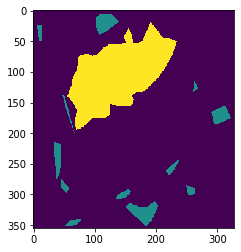

In [7]:
#Plotting the train data
train_imgr = rasterio.open(train_raster1)
show(train_imgr.read(3), cmap='viridis')

Now, we are going to prepare the given images into a table so we can perform a classification

In [8]:
#Getting size of inmages
Xsize = train_img1.RasterXSize
Ysize = train_img1.RasterYSize

#Getting values of position in the array (pixel lins/columns) for train samples
array_X_train = []
array_Y_train = []
for i in range(Xsize):
  for j in range(Ysize):
    array_X_train.append(i)
    array_Y_train.append(j)
xy_train = np.vstack((array_X_train,array_Y_train))
xy_train = np.rollaxis(xy_train,0,2)

#Checking size of array
xy_train.shape



(116440, 2)

In [0]:
#Function do prepare the images into a sort of WEKA ARFF file
def prep_test_img(img):
  stack = img.ReadAsArray()
  stack = np.rollaxis(stack, 0, 3)
  stack.shape

  bands = img.RasterCount
  band_array = []
  for i in range(bands):
    band = img.GetRasterBand(i+1).ReadAsArray()
    band = band.flatten()
    band_array.append(band)
  #Stacking bnds
  img_stack = np.stack(band_array, axis=-1)
  
  img_stack = np.hstack((xy_train,img_stack))
  print('Size of image: ',img_stack.shape)
  return img_stack

def df_crea(stack):
  df_stack = pd.DataFrame(
    data= stack,
    columns = features)
  return df_stack


In [11]:
#Applying function to images
stack1 = prep_test_img(train_img1)
#stack2 = prep_test_img(train_img2)
stack3 = prep_test_img(train_img3)
stack4 = prep_test_img(train_img4)
stack5 = prep_test_img(train_img5)


Size of image:  (116440, 5)
Size of image:  (116440, 5)
Size of image:  (116440, 5)
Size of image:  (116440, 5)


In [0]:
df_stack1 = df_crea(stack1)
#df_stack2 = df_crea(stack2)
df_stack3 = df_crea(stack3)
df_stack4 = df_crea(stack4)
df_stack5 = df_crea(stack5)

In [0]:
#Replacing values
#Classes have values between 0 and 1. As we are using one image per class, then we need to reassign the classes
#df_stack2 = df_stack2.replace({'Class':1},2)
sf_stack3 = df_stack3.replace({'Class':1},3)
df_stack4 = df_stack5.replace({'Class':1},4)
df_stack5 = df_stack5.replace({'Class':1},5)

In [16]:
#Concatenating values
train = pd.concat([df_stack1, df_stack3, df_stack4, df_stack5])
#Checking the values from the stack
print('Minimum value from class: ',train.Class.values.min())
print('Maximum value from class: ',train.Class.values.max())

Minimum value from class:  0.0
Maximum value from class:  5.0


## **2.2. Getting test data**
Second, we are going to open the **test GEOTIFF** File. <br>
The test sample in the very first case is the whole image. <br>
First, we are getting info from the raster so we can add this info to the classified image.

In [0]:
test_path = '/content/drive/My Drive/INPE/2019_3/RADAR/Trabalho Radar/01.Dados entrada/SAR_ciclo1_fase3.tif'
img = gdal.Open(test_path)

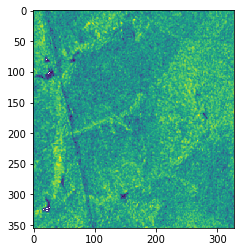

In [20]:
#Opening test_image as check
test_img = rasterio.open(test_path)
plt.imshow(test_img.read(1), cmap='viridis')

In [0]:
#Getting the first raster info do we can ass to the classified image
proj = img.GetProjection()
metadata = img.GetMetadata()

In [22]:
test = prep_test_img(img)
test

Size of image:  (116440, 4)


array([[  0.        ,   0.        , -10.80712665, -17.72855586],
       [  0.        ,   1.        , -10.09416641, -19.52941689],
       [  0.        ,   2.        , -11.02832198, -18.09746183],
       ...,
       [327.        , 352.        , -12.0270942 , -14.96194916],
       [327.        , 353.        , -14.01010976, -12.58440121],
       [327.        , 354.        , -12.55072424, -13.73529449]])

# **3. First RF test <br>**
Example for this website: 
https://chrisalbon.com/machine_learning/trees_and_forests/random_forest_classifier_example/ <br><br>
1 - We're using the entire agricultural field as train sample and the whole image as test sample at first moment <br>
https://towardsdatascience.com/an-implementation-and-explanation-of-the-random-forest-in-python-77bf308a9b76

In [0]:
# Set random seed
np.random.seed(0)

In [59]:
# Show the number of observations for the test and training dataframes
train_dataset = train.values
train_dataset = train_dataset[:,2:-1]
print('Number of bands used for training: ', train_dataset.shape[1])
test_dataset = test
print('Number of observations in the training data:', len(train_dataset))
print('Number of observations in the test data:',len(test_dataset))

Number of bands used for training:  2
Number of observations in the training data: 465760
Number of observations in the test data: 116440


2 - We are using a NumPy Array instead of a Panda DataFrame so it the code is faster to run

When applying ranfom forest, we usualy use the letter "y" as train sample and "X" for test sample.

In [25]:
y = train.values
y = y[:,-1]
print('Size of sample vector: ' ,y.shape)
print('Maximum value of sample vector: ' ,y.max())
print('Minimum value of sample vector: ', y.min())

Size of sample vector:  (465760,)
Maximum value of sample vector:  5.0
Minimum value of sample vector:  0.0


### **3.1. Applying the RF Classifier**
The number of trees is by default equals to 100 <br>
The cirterion is, by default, Gini impurity to measure quality of split

In [0]:
#Multiplying the data by 10,000 so we can perform the RF classifier
tr = train.replace(np.nan, -9999)
tr = tr.values[:,2:-1]
tr = np.array(tr)
tr = tr*10000
train_dataset = tr

In [67]:
# Create a random forest Classifier. By convention, clf means 'Classifier'
clf = RandomForestClassifier(n_jobs=2, oob_score = True, random_state=0)

# Train the Classifier to take the training features and learn how they relate
# to the training y (the species)
clf.fit(train_dataset, y)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=2,
                       oob_score=True, random_state=0, verbose=0,
                       warm_start=False)

### **3.2. Measuring order of importance and quality of split**

### 1 - Getting Out-of-bag (OOB) Accuracy to have an ideal of how well the RF operated. <br>
Bruno's code: https://github.com/menimato/CAP394-Data-Science/blob/master/CAP%20394%20-%20Project.ipynb <br>
Details about OOB score: https://towardsdatascience.com/what-is-out-of-bag-oob-score-in-random-forest-a7fa23d710

In [68]:
#Getting OOb accuracy
print('Our OOB prediction of accuracy is: {oob}%'.format(oob=clf.oob_score_ * 100))

Our OOB prediction of accuracy is: 96.39342150463757%


### 2 - Order of importance
Here we can see the order of importance (feature selection) of each band used for this classification. <br>
The ranking of importance is defined in percentage, as can be seen below.

In [69]:
clf.feature_importances_

array([0.42244762, 0.57755238])

In [70]:
#Defining a Panda DataFrame to organize and sort the data
data = pd.DataFrame({
    'Band': features[2:-1],
    'Importance': 100*clf.feature_importances_,
})
rank  = data.sort_values(by=['Importance'], ascending =False)
rank

,Band,Importance
1,VH,57.755238
0,VV,42.244762


## **3.3. Applying the RF Classifier Model to Test data**
In this moment, we are applying the model to predict the other pixel values

In [0]:
#Removing NaN values from array and mutiplying the data by 10,000
ts = test_dataset[:,2:]
ts = np.array(ts)
ts = ts*10000
ts1 = np.nan_to_num(ts)

In [0]:
# Apply the Classifier we trained to the test data
result = clf.predict(ts1)

### 1- Predicted probabilities
The formed array will show the probabilitie of a pixel to belong to each class


In [87]:
# View the predicted probabilities of the first 10 observations
prediction = clf.predict_proba(ts1)[1:10]

#Class 0 is not used in thiscase
prediction

array([[0.        , 0.        , 1.        , 0.        , 0.        ],
       [0.        , 0.        , 1.        , 0.        , 0.        ],
       [0.        , 0.        , 1.        , 0.        , 0.        ],
       [0.        , 0.        , 1.        , 0.        , 0.        ],
       [0.        , 0.        , 1.        , 0.        , 0.        ],
       [0.        , 0.2       , 0.5       , 0.16666667, 0.13333333],
       [0.        , 0.3       , 0.7       , 0.        , 0.        ],
       [0.        , 0.4       , 0.5       , 0.05      , 0.05      ],
       [0.        , 0.1       , 0.9       , 0.        , 0.        ]])

# **4. Plotting Classified Image**

## **4.1. Reshaping flatenned array into raster original size**
<br>


> _Ysize_ is the number of columns in the raster


> _Xsize_ is the number of lines in the raster







In [0]:
img_res = result.reshape(Ysize,Xsize)

## **4.2. Formatting the plot**

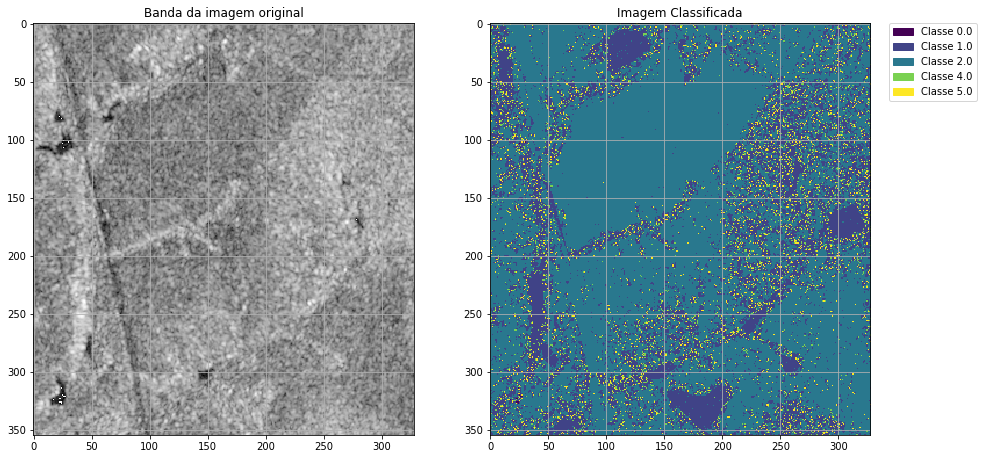

In [90]:
plt.figure(figsize=(15,10))

plt.subplot(121)
plt.title("Banda da imagem original")
plt.imshow(img.GetRasterBand(1).ReadAsArray(), cmap='gray')
plt.grid(True)

values = np.unique(img_res.ravel())
plt.subplot(122)
plt.title("Imagem Classificada")
im = plt.imshow(img_res, cmap='viridis')
# get the colors of the values, according to the 
# colormap used by imshow
colors = [ im.cmap(im.norm(value)) for value in values]
# create a patch (proxy artist) for every color 
patches = [ mpatches.Patch(color=colors[i], label="Classe {l}".format(l=values[i]) ) for i in range(len(values)) ]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
plt.grid(True)
plt.show()

# **5. Quality Assessment**


## **5.1. Prepare train/test datases**
First we need to add the reuslt value as a band to the _test dataset_ as well as do few array modifications.

### *5.1.1.Test Dataset*

In [91]:
#Checking size of data
print('Size of test dataset: ' ,test_dataset.shape)
print('Size of result dataset: ',result.shape)

Size of test dataset:  (116440, 4)
Size of result dataset:  (116440,)


In [0]:
#Changing dimension of array so we can concatenate it
result = np.expand_dims(result, 1)

In [93]:
#Concatenating and checking sizes of stacked arrays
print('Size of bands:      ',test_dataset.shape)
print('Size of band Class: ',result.shape)
result_dataset = np.hstack((test_dataset,result))
print('Size of complested dataframe:  ',result_dataset.shape)

Size of bands:       (116440, 4)
Size of band Class:  (116440, 1)
Size of complested dataframe:   (116440, 5)


In [0]:
#Turning the dataset into a dataframe
test_df = pd.DataFrame(
    data = result_dataset,
    columns = features)

In [95]:
#The first 5 lines of the test dataset as Dataframe
test_df.head()

,x,y,VV,VH,Class
0,0.0,0.0,-10.807127,-17.728556,2.0
1,0.0,1.0,-10.094166,-19.529417,2.0
2,0.0,2.0,-11.028322,-18.097462,2.0
3,0.0,3.0,-11.527090,-15.790124,2.0
4,0.0,4.0,-11.518733,-15.521051,2.0


### *5.1.2. Train Dataset*

In [96]:
#Showing first 5 lines of training dataset
train.head()

,x,y,VV,VH,Class
0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0
2,0.0,2.0,0.0,0.0,0.0
3,0.0,3.0,0.0,0.0,0.0
4,0.0,4.0,0.0,0.0,0.0


In [0]:
#Reassigning value to NaN (Not a Number) and getting the wrong classified values out from the dataframe
#Those wrong classified values are the data not in the training sample
tr_df = train
#tr_df = tr_df.replace(0, np.nan)
tr_df = tr_df.loc[(tr_df['VV'] != 0)]
tr_df = tr_df.loc[(tr_df['VH'] != 0)]

### *5.1.3. Merging equal (x,y) values from train and test datsets*

In [101]:
# Getting a matrix with the (x,y) position on TEST are equal to such respective value on TRAIN values
df3 = test_df.merge(tr_df, on=['x','y'], how='inner')
df3.head()

,x,y,VV_x,VH_x,Class_x,VV_y,VH_y,Class_y
0,5.0,302.0,-10.983268,-11.618924,1.0,-6.505735,-11.011690,1.0
1,5.0,302.0,-10.983268,-11.618924,1.0,-10.983268,-11.618924,1.0
2,5.0,302.0,-10.983268,-11.618924,1.0,-6.395858,-14.509307,4.0
3,5.0,302.0,-10.983268,-11.618924,1.0,-6.395858,-14.509307,5.0
4,5.0,303.0,-11.942504,-12.962958,1.0,-7.183835,-12.412693,1.0


## **5.2. Confuion Matrix, Kappa Coefficient and Overall Accuracy**
 



In [102]:
#The confusion matrix comparing all the classes from the data
confusion = confusion_matrix(tr_df['Class'], df3['Class_x'])
confusion

array([[ 1020,  7615,     0,     3],
       [12593, 49230,    16,    17],
       [  102,  4217,     0,     0],
       [ 3277,  1038,     4,     0]])

The kappa coefficient and overall accuracy are given by:

In [103]:
kappa = sklearn.metrics.cohen_kappa_score(tr_df['Class'], df3['Class_x'])
oa = accuracy_score(tr_df.Class, df3.Class_x, normalize=True)

print('The kappa coefficient is: % 5.4f'%(kappa))
print('The overall accuracy is: % 5.4f%%'%(oa*100) )

The kappa coefficient is: -0.0052
The overall accuracy is:  63.5015%
